# Mental Health on Social Media - NLP Project

Denise Emmermacher / Raquel Bux Sanz

## Introduction

Social Media has a big impact in our lives and mental health. Studies show us that toxic behaviour and also cyberbullyng can affect directly in our mood, possibly creating conditions that can contribute for some specific sintoms of depression, anxiety and other deseases.

Nowadays it is possible to see that through these platforms (like Reddit, Twitter, Facebook and others), we can also know more about the person that is behind the screen and detect, by the language, if this person might be suffering from depression or not.

In our project we intend to use Natural Language Processing (NLP) to detect posts and comments with depressive content in order to help people to improve their emotional and mental health.

## Datasets

We are going to work with 3 datasets: 

1) Posts of Reddit

This dataset was found in Kaggle and contain posts of Reddit, collected from Dec 16th 2008 until Jan 2th 2021, using Pushshift API. The dataset assumes posts collected from 'SuicideWatch' (an intensive monitoring process used to ensure that any person cannot attempt suicide - https://reddit.com/r/SuicideWatch/) contains suicide related content. Similarly we have other classes 'depression' (https://reddit.com/r/depression/) and 'teenagers' (https://reddit.com/r/teenagers/) collected from respective subreddits.

The target column (class) detects if the post is "depressive" (1) or "not-depressive" (0).

Key figures:

- 232.074 rows 
- 3 columns 
- 1 text column
- 2 numeric columns

2) Tweets with depression content

The dataset that we found in Kaggle was taken by the websraper with the name of TWINT using the keyword depression by scraping all tweets in an one day span. The tweets which taken as the result of the scrapper may contain tweets that do not shows the user have the depression, such as tweets such as tweets linking to articles about depression. 

- 10314 rows 
- 3 columns
- 1 text column
- 2 numeric columns

3) Positive reviews on IMDb

This is a dataset for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. 

- 50000 rows 
- 2 columns
- 1 text column
- 1 numeric columns





## Strutcture of this Notebook

NLP (using the dataset of Posts on Reddit)
- Cleaning data, Merging Posts, Text Cleaning, Tokenizing Corpus, Reducing Corpus, Stemming and Creating Dataframe for Making Predictions based on the Tree Model;
- Cleaning data and using TDF-DF to generate other model of Tree, with a greater amount of keywords. This model will be optimized with Grid Search.

EDA
- Cleaning data of the dataset we used to make EDA of the influence of Social Media in the mood and mental health of people (Dataset from ScienceDirect, a website which provides access to a large bibliographic database of scientific and medical publications of the Dutch publisher Elsevier);
- The EDA will be structured in tableau and in the canva presentation.

## Importing libraries

In [276]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import seaborn as sns
import re
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, classification_report 
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

# Cleaning Data

## Data cleaning

The first step that we took for the cleaning was to change the words "suicide" and "non-suicide" for 1 and 0. The reason is because there's not only content about suicide, but also about depression and not every depressed person is able to commit suicide.

In [277]:
sd = pd.read_csv ('Suicide_Detection.csv')
sd

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


In [278]:
sd['class'] = sd['class'].map({'suicide': 1, 'non-suicide': 0})

In [279]:
sd

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,1
1,3,Am I weird I don't get affected by compliments...,0
2,4,Finally 2020 is almost over... So I can never ...,0
3,8,i need helpjust help me im crying so hard,1
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",1
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,0
232070,348106,You how you can tell i have so many friends an...,0
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,0
232072,348108,The usual stuff you find hereI'm not posting t...,1


Checking the missing values.

In [281]:
sd.isnull().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

Dropping the column "Unnamed: 0"

In [282]:
sd = sd[['text','class']]
sd.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [283]:
sd['class'].value_counts()

1    116037
0    116037
Name: class, dtype: int64

The classes are balanced. That's a good sign. 

## Splitting in two DF's

Now we are going to analyse the amount of words each class have. For that we will split the dataframe in two:


- dep: Only containing the posts labeled with depressive content;
- ndep: containing the posts that are considered not-depressive.

In [284]:
dep = sd[sd['class'] == 1]
dep.shape

(116037, 2)

In [285]:
ndep = sd[sd['class'] == 0]
ndep.shape

(116037, 2)

## Filtering the lenght

Now let's get the length of each type of class adding the column "length" in the two dataframes, using the lambda function. With this we will know the number of words of each post. This will help us to filter the data for a better performance of the model.

In [286]:
dep['length'] = list(map(lambda x: len(str(x).split()), dep['text']))

In [287]:
dep.head()

,text,class,length
0,Ex Wife Threatening SuicideRecently I left my ...,1,143
3,i need helpjust help me im crying so hard,1,9
4,"I’m so lostHello, my name is Adam (16) and I’v...",1,438
5,Honetly idkI dont know what im even doing here...,1,291
6,[Trigger warning] Excuse for self inflicted bu...,1,243


Checking the outliers... We can see that the majority of the posts have not more that 1.000 words, meanwhile the outliers can reach around 10.000 words.

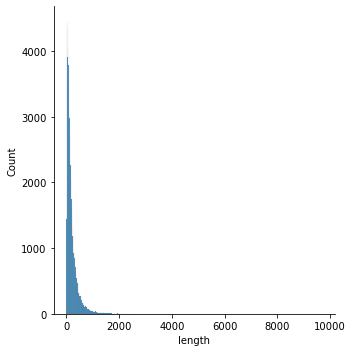

In [288]:
sns.displot(x=dep['length'])

In [289]:
dep['length'].describe()

count    116037.000000
mean        202.662168
std         255.309193
min           1.000000
25%          60.000000
50%         127.000000
75%         251.000000
max        9684.000000
Name: length, dtype: float64

The median of words are 127.
A reasonable guess will be to filter out posts under the lenght of 150 words - a value a little bit bigger than the median.

In [290]:
dep = dep[dep['length'] < 150]
dep.shape

(65179, 3)

Repeating the same process with the dataframe of not-depressive posts: creating a column called "lenght" in the dataframe.

In [291]:
ndep['length'] = list(map(lambda x: len(str(x).split()), ndep['text']))

In [292]:
ndep.head()

,text,class,length
1,Am I weird I don't get affected by compliments...,0,27
2,Finally 2020 is almost over... So I can never ...,0,26
8,"Everyone wants to be ""edgy"" and it's making me...",0,195
15,Fuck the verizon smart family app I can’t even...,0,19
17,"Well, Im screwed. I locked myself in the schoo...",0,26


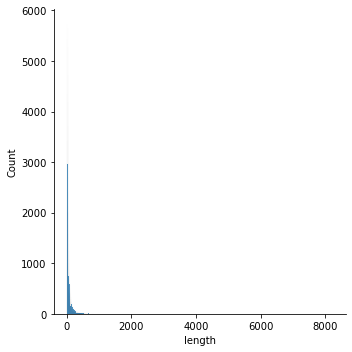

In [293]:
sns.displot(x=ndep['length'])

Posts with depressive content have a lot of more characters than the not-depressive posts. 
Here we can see the difference of the numbers of words in the post. Not depressive posts tend to have smaller texts.

In [295]:
ndep['length'].describe()

count    116037.000000
mean         61.188302
std         139.292553
min           2.000000
25%          19.000000
50%          31.000000
75%          60.000000
max        8220.000000
Name: length, dtype: float64

The median is also smaller. Now we will filter the posts that are smaller than one value near the median (31). We think that under 36 words is a good way to filter.

In [296]:
ndep = ndep[ndep['length'] < 36]
print (dep.shape)
print (ndep.shape)

(65179, 3)
(64999, 3)


## Concatenating

After filtering the data by the lenght of the text of each class (that's the way we found to work with a final data that keeps the balance of the target column like in the original data), we will concatenate the two dataframes...

In [297]:
conc = pd.concat([dep, ndep], axis=0)

In [298]:
conc

,text,class,length
0,Ex Wife Threatening SuicideRecently I left my ...,1,143
3,i need helpjust help me im crying so hard,1,9
7,It ends tonight.I can’t do it anymore. \nI quit.,1,9
10,I took the rest of my sleeping pills and my pa...,1,29
11,Can you imagine getting old? Me neither.Wrinkl...,1,74
...,...,...,...
232064,How ba-a-ad can i be? I’m just doin’ what come...,0,26
232069,If you don't like rock then your not going to ...,0,19
232070,You how you can tell i have so many friends an...,0,31
232071,pee probably tastes like salty tea😏💦‼️ can som...,0,14


## Getting a sample

Reducing the dataframe to get around 70.000 rows.

In [299]:
sam = conc.sample(frac=0.54)

In [300]:
sam

,text,class,length
103420,I finally did it!! I finally got caught up on ...,0,26
217764,For everyone who lifts what are your pr’s I am...,0,20
103941,I need to talk to someone...I can't trust anyo...,1,30
201572,Growing painsReally close to losing it 😰,1,7
187318,things to dodoes anyone have any ideas of what...,1,51
...,...,...,...
209666,My cursor just fucking dipped what the fuck I’...,0,32
32501,say/ask something and i’ll have a conversation...,0,17
70234,I'm always right Why? Because I'm me obviously...,0,18
44314,Girlfriend has a plan to kill herselfShe’s bee...,1,115


##  Depression dataframe

The first dataframe had to much texts about suicide, so we wanted to put more texts about depression for a better performance of the model. Hence, the scrapped tweets need to be manually check for the better testing results. 

In [301]:
tweets = pd.read_csv ('sentiment_tweets3.csv')
tweets

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1


In [302]:
tweets = tweets[['message to examine','label (depression result)']]
tweets

,message to examine,label (depression result)
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


In [303]:
tweets.rename(columns={'message to examine':'text','label (depression result)':'class'}, 
          inplace=True, errors='raise')

In [304]:
tweets

,text,class
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


In [305]:
tweets.drop(10313,inplace=True, axis=0)

In [306]:
tweets.isnull().sum()

text     0
class    0
dtype: int64

In [307]:
tweets['class'].value_counts()

0    8000
1    2313
Name: class, dtype: int64

We are goint to drop the tweets that doesn't have content about depression, because we already have this kind of content in our first dataset:

In [308]:
to_drop = tweets[tweets['class'] == 0].index

In [309]:
tweets.drop(to_drop,inplace=True, axis=0)

In [310]:
tweets

,text,class
8000,The lack of this understanding is a small but ...,1
8001,i just told my parents about my depression and...,1
8002,depression is something i don't speak about ev...,1
8003,Made myself a tortilla filled with pb&j. My de...,1
8004,@WorldofOutlaws I am gonna need depression med...,1
...,...,...
10308,Many sufferers of depression aren't sad; they ...,1
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1


In [311]:
voc = pd.concat([sam, tweets], axis=0)

## Growing the vocabulary

We also noticed that we needed to balance the dataframe with more not-depressive tweets, so that the model could better detect content that is not related to depression. For that we took a dataset with some positive rewiews about movies from imdb.

In [145]:
imdb = pd.read_csv ('IMDB Dataset.csv')
imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [146]:
imdb['sentiment'] = imdb['sentiment'].map({'negative': 1, 'positive': 0})

In [147]:
imdb.rename(columns={'review':'text','sentiment':'class'}, 
          inplace=True, errors='raise')

In [148]:
to_drop = imdb[imdb['class'] == 1].index

In [149]:
imdb.drop(to_drop,inplace=True, axis=0)

In [150]:
imdb

,text,class
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0
5,"Probably my all-time favorite movie, a story o...",0
...,...,...
49983,"I loved it, having been a fan of the original ...",0
49985,Imaginary Heroes is clearly the best film of t...,0
49989,I got this one a few weeks ago and love it! It...,0
49992,John Garfield plays a Marine who is blinded by...,0


In [312]:
final = pd.concat([voc, imdb], axis=0)

In [313]:
final['class'].value_counts()

0    60078
1    37531
Name: class, dtype: int64

In [ ]:
#category_1 = condata[condata[‘class’] == 1]
#category_0 = condata[condata[‘class’] == 0]

In [ ]:
#print(category_1.shape)
#print(category_0.shape)

In [ ]:
#category_1_down = category_1.sample(len(category_0))
#print(category_1_down.shape)
#print(category_0.shape)

In [ ]:
#new_data_down= pd.concat([category_1_down, category_0], axis=0)
#new_data_down

In [ ]:
#shuffling the data
#new_data_down = new_data_down.sample(frac=1)
#new_data_down[‘class’].value_counts()

Now the data are not balanced. We decided to do a downdampling to balance it.
After downsampling...

In [347]:
data = pd.read_csv ('Downsampled.csv')
data

,Unnamed: 0,text,class
0,24273,"Compared to Battle of Britain, this is a real ...",0
1,16282,In keeping with Disney's well-known practice o...,1
2,13396,This documentary is absolutely fantastic. I wa...,0
3,49315,The idea's which are shown in this film are wi...,0
4,38269,In this crackerjack noir thriller from Columbi...,0
...,...,...,...
49995,23890,"It happens often, while growing up, a Hollywoo...",0
49996,231005,I've made a descisionI have multiple tests in ...,1
49997,21790,I first saw this movie at a premiere-party in ...,0
49998,103912,September 3rd is my date. I can justify no fur...,1


## nltk tagger

Now we are goint to download the packages to tag the words using nltk.tagger. Here is a brief explanation why tagging is important in NLP:

Many natural language utterances are ambiguous, forcing us to use other sources of information to aid interpretation.

Most language processing systems need to recognize and interpret the linguistic structures that exist in a sequence of words. This task is virtually impossible if all we know about each word is its textual representation. The process of classifying words in this sense, and tagging them accordingly, is known as discourse-part tagging (or 'grammatical class tagging'). This process will help the machine to better 'interpret' the context of texts. The set of tags used for a particular task is known as a tag set.

In [314]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/deni.emmer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deni.emmer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/deni.emmer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/deni.emmer/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

# EDA

Just for a small analysis about our data, we plottet two wordclowds. This first one is with all the content we find in the dataset:

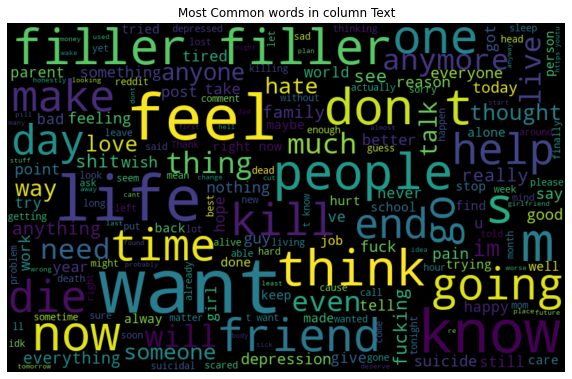

In [317]:
cloudwords = ' '.join([text for text in voc['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(cloudwords)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Text")
plt.show();

This second have the most frequent words written by the people with depressive tendencies:

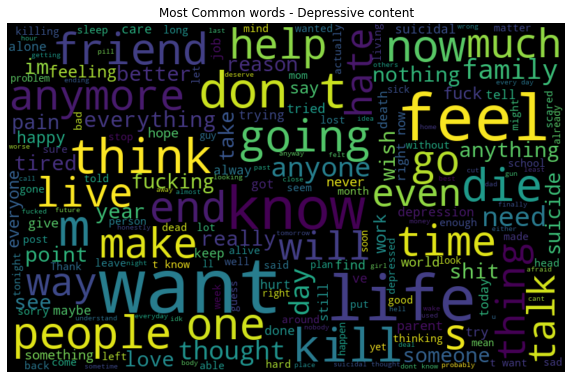

In [318]:
cloudwords_dep = ' '.join([text for text in dep['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(cloudwords_dep)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words - Depressive content")
plt.show();

# NLP - Detection of posts with depressive content
## Creating the model

### Defining a function to clean a post

In [348]:
def clean_post(x):
    x = str(x).lower().replace("\\","").replace("_"," ")
    x = re.sub(r'\W+',' ',x) # Replace everything non-alpahnumeric by ' '
    x = re.sub(r'\s+',' ',x) # Replace one or more whitespaces by  ' '
    x = re.sub(r'\d+',' ',x) # Replace one or more digits by  ' '
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", x) # Replace e-mails by ''
    # Replace urls by ''
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , x) 
    # Replace html tags by ''
    x = BeautifulSoup(x, 'html.parser').get_text().strip()
    x = x.replace(' br ',' ')

    return x


In [349]:
posts_cleaned = data.copy()

In [168]:
posts_cleaned

,text,class
2,This world isn't right for meLots of people br...,1
3,Can somebody be in my corner please?The mistak...,1
4,I have such an in detail plan w my friend to k...,1
6,almost did it tonighti had the bottle of pills...,1
8,welp. that's that.check my post history if you...,1
...,...,...
49983,"I loved it, having been a fan of the original ...",0
49985,Imaginary Heroes is clearly the best film of t...,0
49989,I got this one a few weeks ago and love it! It...,0
49992,John Garfield plays a Marine who is blinded by...,0


In [350]:
posts_cleaned = posts_cleaned[['text','class']]

In [55]:
posts_cleaned.head()

,text,class
2,This world isn't right for meLots of people br...,1
3,Can somebody be in my corner please?The mistak...,1
4,I have such an in detail plan w my friend to k...,1
6,almost did it tonighti had the bottle of pills...,1
8,welp. that's that.check my post history if you...,1


In [351]:
posts_cleaned['text'] = posts_cleaned['text'].apply(lambda x: clean_post(x))

In [138]:
posts_cleaned

,text,class
2,this world isn t right for melots of people br...,1
3,can somebody be in my corner please the mistak...,1
4,i have such an in detail plan w my friend to k...,1
6,almost did it tonighti had the bottle of pills...,1
8,welp that s that check my post history if you ...,1
...,...,...
49983,i loved it having been a fan of the original s...,0
49985,imaginary heroes is clearly the best film of t...,0
49989,i got this one a few weeks ago and love it it ...,0
49992,john garfield plays a marine who is blinded by...,0


In [177]:
posts_cleaned.to_csv("cleaned.csv")

### Reducing the corpus

In a large text corpus, some words that carry very little meaningful information will be present to concatenate terms(e.g. “the”, “a”, “is” in English). They are useless for our pourposses and could shadow the frequencies of rarer yet more interesting terms. We will create a list with the set of stop words from nltk libraryin order to re-weight the count features into floating point values suitable for usage by a classifier, through the tf–idf transform.

In [352]:
stop_words = list(stopwords.words('english')) 
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Cleaning the punctuation marks in stop words...

In [353]:
for i in range(len(stop_words)):
    stop_words[i] = re.sub(r"\s*'\s*\w*","",stop_words[i])

#stop_words = [word for word in list(np.unique(stop_words)) if len(word) > 1]
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 'you',
 'you',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more'

### TF-IDF 

In [354]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (2,2), analyzer = 'word',
                       stop_words = stop_words )

In [355]:
X = tidf.fit_transform(posts_cleaned['text'])
y = posts_cleaned['class']

Inspecting the features of the bigrams the model:

In [1243]:
tidf.get_feature_names()

['aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'ab channel',
 'able afford',
 'able anything',
 'able change',
 'able control',
 'able enjoy',
 'able feel',
 'able find',
 'able get',
 'able go',
 'able handle',
 'able help',
 'able hold',
 'able keep',
 'able kill',
 'able live',
 'able make',
 'able move',
 'able post',
 'able see',
 'able sleep',
 'able stop',
 'able take',
 'able talk',
 'able tell',
 'able think',
 'able use',
 'able walk',
 'able work',
 'absolute shit',
 'absolutely fucking',
 'absolutely hate',
 'absolutely nothing',
 'absolutely one',
 'absolutely reason',
 'absolutely terrified',
 'abt anything',
 'abused child',
 'abused parents',
 'abusive ex',
 'abusive family',
 'abusive father',
 'abusive mother',
 'abusive parents',
 'abusive relationship',
 'accept fact',
 'access gun',
 'access guns',
 'accident something',
 'accomplish anything',
 'accomplished anything',
 'accomplished nothing',
 'achieve anything',
 'acknowledge existence',
 'ac

In [320]:
len(tidf.get_feature_names())

20000

## Train test split

In [356]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [1084]:
type(X_train)

scipy.sparse.csr.csr_matrix

## Generating the model

In [357]:
rf = RandomForestClassifier(max_depth=100, n_estimators=50)

y_train = y_train.astype('int')
y_test  = y_test.astype('int')

rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

RandomForestClassifier(max_depth=100, n_estimators=50)

## Model evaluation

In [358]:
model_performance_class(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.81
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     17493
           1       0.99      0.82      0.90     17507

    accuracy                           0.91     35000
   macro avg       0.92      0.91      0.91     35000
weighted avg       0.92      0.91      0.91     35000

Results obtained for the TEST SET
The Cohen's Kappa is: 0.68
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      7507
           1       0.94      0.73      0.82      7493

    accuracy                           0.84     15000
   macro avg       0.86      0.84      0.84     15000
weighted avg       0.86      0.84      0.84     15000



# Grid Search

In [321]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [10, 20,50],
    'min_samples_split': [2, 4],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt']
    }
clf = RandomForestClassifier(random_state=100)

In [325]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [359]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [10, 20, 50]},
             return_train_score=True)

In [327]:
grid_search.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

In [360]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(random_state=0, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=4, n_estimators=50)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

0.8845714285714286


In [253]:
clf.fit(X_train, y_train)

y_train_pred_clf = clf.predict(X_train)
y_test_pred_clf  = clf.predict(X_test)

RandomForestClassifier(max_features='sqrt', min_samples_split=4,
                       n_estimators=50, random_state=0)

In [361]:
model_performance_class(y_train, y_train_pred_clf, y_test, y_test_pred_clf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17493
           1       1.00      1.00      1.00     17507

    accuracy                           1.00     35000
   macro avg       1.00      1.00      1.00     35000
weighted avg       1.00      1.00      1.00     35000

Results obtained for the TEST SET
The Cohen's Kappa is: 0.77
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      7507
           1       0.90      0.86      0.88      7493

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



# Recognizer

In [362]:
def recognizer():
    sentence = input("How are you feeling? \n\n")
    list_sentence = []
    list_sentence.append(clean_post(sentence))
    X = tidf.transform(list_sentence)
    predict= rf.predict(X)[0]
    if predict == 0:
        print("\n")
        print("DETECTON:")
        print("This person may be not depressed.")
    else:
        print("\n")
        print("ALERT:")
        print("This person may be depressed.")

In [386]:
recognizer()

How are you feeling? 

Everything fucking hurts. My old friend depression is back again. I know how to help myself - eat well, do exercise, take a shower etc. But I just don't have the energy. All I want to do is lie on the couch, eat chips and cry. I don't want to see anyone or talk to anyone. I'm not ok. I'm not terrible, but I'm also not ok. Nothing is fun, nothing is worthwhileml. Everything is meh. I feel so lonely and upset. I just want to cry. Sending love to you all out there.


ALERT:
This person may be depressed.


# EDA - Mental Health and Social Media

## Cleaning Data

Cleaning the Dataset from ScienceDirect with information of Social Media and Mental Health for the introduction of our canvas presentation.

In [149]:
feelings = pd.read_excel('feelings.xlsx')
feelings

,Timestamp,"1. Do you have a social media account? (e.g., Facebook, Twitter, etc.)",2. Which social media account do you use usually?,3. Which device do you usually use to connect social media?,4. Which type of internet connection do you use?,5. How long have you been using a social media account?,6. How frequently do you post (upload status or add photos/videos) on social media?,7. How much time do you spend daily in social media?,8. When do you usually use social media?,9. How many friends do you have on social media?,...,"10. In last 30 days, How many times, I cough or snore loudly?","11. In last 30 days, How many times, I feel too cold?","12. In last 30 days, How many times, I feel too hot?","13. In last 30 days, How many times, I saw bad dreams?","14. In last 30 days, How many times, I have pain during sleep?","15. In last 30 days, How many times, I having trouble sleeping for any other reason?","16. In last 30 days, In last month, have you take medicines for sleep?","17. In last month, how many times you cannot sleep due to any program or other important case?","18. In last month, how many times you face problems to maintain program or other important case?","19. During the past month, how would you rate your sleep quality overall?"
0,2021-02-20 21:56:49.755,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),5-10 years,Less than 1 per day,1-3 hours,Frequently at anytime,Less than 500,...,Not during last month,Less then once a week,Not during last month,Not during last month,Not during last month,Less then once a week,Not during last month,Less then once a week,Less then once a week,Farely good
1,2021-02-20 23:32:52.030,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),5-10 years,3-5 per day,More than 5 hours,Frequently at anytime,500-2000,...,Less then once a week,Less then once a week,Three or more in week,Less then once a week,Not during last month,Not during last month,Less then once a week,Less then once a week,Less then once a week,Very bad
2,2021-02-16 21:03:59.071,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),5-10 years,Less than 1 per day,3-5 hours,Night to late night,Less than 500,...,Not during last month,Not during last month,Less then once a week,Less then once a week,Three or more in week,Three or more in week,Not during last month,Three or more in week,Once or twice a week,Very bad
3,2021-03-01 10:03:23.049,Yes,Twitter,Mobile Phone,Mobile data,Less than 2-year,Less than 1 per day,3-5 hours,Frequently at anytime,500-2000,...,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Farely good
4,2021-02-27 19:27:54.278,Yes,Twitter,Mobile Phone,Broadband (Wi-Fi),Less than 2-year,More than 5 per day,More than 5 hours,Night to late night,2000-4000,...,Not during last month,Not during last month,Not during last month,Not during last month,Less then once a week,Less then once a week,Less then once a week,Less then once a week,Less then once a week,Farely good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2021-02-22 12:54:28.782,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),More than 10 years,Less than 1 per day,1-3 hours,Night to late night,Less than 500,...,Not during last month,Not during last month,Not during last month,Less then once a week,Not during last month,Less then once a week,Not during last month,Not during last month,Not during last month,Farely bad
787,2021-02-17 04:50:31.193,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),5-10 years,Less than 1 per day,Less than 1 hour,Frequently at anytime,Less than 500,...,Not during last month,Once or twice a week,Less then once a week,Less then once a week,Not during last month,Less then once a week,Less then once a week,Once or twice a week,Once or twice a week,Very bad
788,2021-02-20 14:17:34.046,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),5-10 years,More than 5 per day,3-5 hours,Frequently at an

In [150]:
feelings.isnull().values.sum()

2

In [151]:
feelings[feelings.isnull().any(axis=1)]

,Timestamp,"1. Do you have a social media account? (e.g., Facebook, Twitter, etc.)",2. Which social media account do you use usually?,3. Which device do you usually use to connect social media?,4. Which type of internet connection do you use?,5. How long have you been using a social media account?,6. How frequently do you post (upload status or add photos/videos) on social media?,7. How much time do you spend daily in social media?,8. When do you usually use social media?,9. How many friends do you have on social media?,...,"10. In last 30 days, How many times, I cough or snore loudly?","11. In last 30 days, How many times, I feel too cold?","12. In last 30 days, How many times, I feel too hot?","13. In last 30 days, How many times, I saw bad dreams?","14. In last 30 days, How many times, I have pain during sleep?","15. In last 30 days, How many times, I having trouble sleeping for any other reason?","16. In last 30 days, In last month, have you take medicines for sleep?","17. In last month, how many times you cannot sleep due to any program or other important case?","18. In last month, how many times you face problems to maintain program or other important case?","19. During the past month, how would you rate your sleep quality overall?"
469,2021-02-19 23:59:39.525,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),5-10 years,Less than 1 per day,Less than 1 hour,Frequently at anytime,Less than 500,...,Once or twice a week,Three or more in week,Less then once a week,Less then once a week,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Farely good
755,2021-03-06 23:07:04.364,Yes,Facebook,Tablet,Broadband (Wi-Fi),2-5 years,1-2 per day,3-5 hours,Evening,500-2000,...,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Farely good


In [152]:
feelings.dropna(inplace=True)

In [153]:
feelings

,Timestamp,"1. Do you have a social media account? (e.g., Facebook, Twitter, etc.)",2. Which social media account do you use usually?,3. Which device do you usually use to connect social media?,4. Which type of internet connection do you use?,5. How long have you been using a social media account?,6. How frequently do you post (upload status or add photos/videos) on social media?,7. How much time do you spend daily in social media?,8. When do you usually use social media?,9. How many friends do you have on social media?,...,"10. In last 30 days, How many times, I cough or snore loudly?","11. In last 30 days, How many times, I feel too cold?","12. In last 30 days, How many times, I feel too hot?","13. In last 30 days, How many times, I saw bad dreams?","14. In last 30 days, How many times, I have pain during sleep?","15. In last 30 days, How many times, I having trouble sleeping for any other reason?","16. In last 30 days, In last month, have you take medicines for sleep?","17. In last month, how many times you cannot sleep due to any program or other important case?","18. In last month, how many times you face problems to maintain program or other important case?","19. During the past month, how would you rate your sleep quality overall?"
0,2021-02-20 21:56:49.755,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),5-10 years,Less than 1 per day,1-3 hours,Frequently at anytime,Less than 500,...,Not during last month,Less then once a week,Not during last month,Not during last month,Not during last month,Less then once a week,Not during last month,Less then once a week,Less then once a week,Farely good
1,2021-02-20 23:32:52.030,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),5-10 years,3-5 per day,More than 5 hours,Frequently at anytime,500-2000,...,Less then once a week,Less then once a week,Three or more in week,Less then once a week,Not during last month,Not during last month,Less then once a week,Less then once a week,Less then once a week,Very bad
2,2021-02-16 21:03:59.071,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),5-10 years,Less than 1 per day,3-5 hours,Night to late night,Less than 500,...,Not during last month,Not during last month,Less then once a week,Less then once a week,Three or more in week,Three or more in week,Not during last month,Three or more in week,Once or twice a week,Very bad
3,2021-03-01 10:03:23.049,Yes,Twitter,Mobile Phone,Mobile data,Less than 2-year,Less than 1 per day,3-5 hours,Frequently at anytime,500-2000,...,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Not during last month,Farely good
4,2021-02-27 19:27:54.278,Yes,Twitter,Mobile Phone,Broadband (Wi-Fi),Less than 2-year,More than 5 per day,More than 5 hours,Night to late night,2000-4000,...,Not during last month,Not during last month,Not during last month,Not during last month,Less then once a week,Less then once a week,Less then once a week,Less then once a week,Less then once a week,Farely good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2021-02-22 12:54:28.782,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),More than 10 years,Less than 1 per day,1-3 hours,Night to late night,Less than 500,...,Not during last month,Not during last month,Not during last month,Less then once a week,Not during last month,Less then once a week,Not during last month,Not during last month,Not during last month,Farely bad
787,2021-02-17 04:50:31.193,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),5-10 years,Less than 1 per day,Less than 1 hour,Frequently at anytime,Less than 500,...,Not during last month,Once or twice a week,Less then once a week,Less then once a week,Not during last month,Less then once a week,Less then once a week,Once or twice a week,Once or twice a week,Very bad
788,2021-02-20 14:17:34.046,Yes,Facebook,Mobile Phone,Broadband (Wi-Fi),5-10 years,More than 5 per day,3-5 hours,Frequently at an

In [154]:
print(feelings.columns)

Index(['Timestamp',
       '1. Do you have a social media account? (e.g., Facebook, Twitter, etc.)',
       '2. Which social media account do you use usually?',
       '3. Which device do you usually use to connect social media?',
       '4. Which type of internet connection do you use?',
       '5. How long have you been using a social media account?',
       '6. How frequently do you post (upload status or add photos/videos) on social media? ',
       '7. How much time do you spend daily in social media?',
       '8. When do you usually use social media?',
       '9. How many friends do you have on social media?',
       '10. How many friends do you know personally in social media? ',
       '11. How many groups you are tagged in social media?',
       '12. What is your main purpose for using social media (e.g. Facebook)?',
       '13. What contents do you mainly look for in your social media news feed?',
       '14.Do you believe social media is a good thing?',
       '15. When you 

In [155]:
feelings.drop(['4. Which type of internet connection do you use?',
         '10. In last 30 days, How many times, I cough or snore loudly?', 
         '11. In last 30 days, How many times, I feel too cold?', 
         '12. In last 30 days, How many times, I feel too hot?', 
         '17. In last month, how many times you cannot sleep due to any program or other important case?', 
         '11. How many groups you are tagged in social media?', 
         '12. What is your main purpose for using social media (e.g. Facebook)?', 
         '13. What contents do you mainly look for in your social media news feed?', 
         '16. Have you ever experienced peer pressure due to social media?',
         '29. Living with-',
         '30. Body weight (Kg)',
         '31. Height (m)',
         '32. Smoking habit',
         '1. In the past 30 days, do you feel lack of companionship?',
         '4. In the last 30 days, I feel isolated from others.',
         '6. In the last 30 days, feeling bad about yourself-or that you are a failure or have let yourself or your family down.',
         '8. In the last 30 days, moving or speaking so slowly or the opposite-moving around a lot more than usual.',
         '7. In the last 30 days, I am an outgoing person.',
         '3. In the last 30 days, I am worrying too much about different things.',
         '10. In last 30 days, How many times, I cough or snore loudly?',
         '13. In last 30 days, How many times, I saw bad dreams?',
         '17. In last month, how many times you cannot sleep due to any program or other important case?',
         '7. In the last 30 days, I am feeling afraid as if something awful might happen.', 
         '5.  How many hours were you in bed?', 
         '8. In last 30 days, How many times, I had to get up to use the bathroom?', 
         '15. In last 30 days, How many times, I having trouble sleeping for any other reason?', 
         '18. In last month, how many times you face problems to maintain program or other important case?', 
        '23. Marital Status', '24. Religion', '25. Education', '26. Profession', '6. In the last 30 days, people are around me but not with me.',
        '8. In the last 30 days, I can find companionship when I want it.', '2. In the last 30 days, I an not being able to stop or control worrying', '4. In the last 30 days, I felt trouble in relaxing.',  "5. In the last 30 days, I am being so restless that it's hard to sit still", '3. When have you usually gotten up in the morning?', '1. Do you have a social media account? (e.g., Facebook, Twitter, etc.)', 'Timestamp'], axis = 1, inplace = True)
         
         
         
         
         

In [156]:
feelings.rename(columns={ 
                   '2. Which social media account do you use usually?': 'most_used_platform', 
                   '3. Which device do you usually use to connect social media?': 'device_type',
                   '5. How long have you been using a social media account?': 'sm_since_when',
                   '6. How frequently do you post (upload status or add photos/videos) on social media? ': 'frequency_of_posts',
                   '7. How much time do you spend daily in social media?': 'time_spent_daily',
                   '8. When do you usually use social media?': 'moment_of_the_day',
                   '9. How many friends do you have on social media?': 'amount_of_followers',
                   '10. How many friends do you know personally in social media? ' :'followers_you_know_personally',
                   '14.Do you believe social media is a good thing?' : 'finds_social_media_good', 
                   '15. When you see something in social media, do you instantly believe it?': 'believe_everything_in_social_media',
                   "17. Does your emotion get influenced by other's posts (success, failure, loss)? " : "emotions_influenced_by_others_posts",
                   '18. Have you ever compared yourself with other’s success or luxurious life?' : 'comparison_with_others',
                   '19. Do you think, your mental wellbeing would be better if you do not use social media?' : 'mental_health_would_be_better_without_sm',
                   '20. If answer is yes, are you trying to control that thing and trying to reduce the use of social media?' : 'try_to_reduce_sm',
                   '21. Please write your age in years (number).': 'age',
                   '22. Gender' : 'gender',
                   '27. Monthly income' : 'monthly_income',
                   '28. Area of residence': 'area_of_residence',
                   '2. In the past 30 days, there is no one I can turn to': 'no_one_i_can_turn_to',
                   '3. In the past 30 days, I feel left out.': 'feel_left_out',
                   '5. In the last 30 days, I am unhappy being so withdrawn.': 'feel_withdrawn',
                   '1 In the last 30 days, little interest or pleasure in doing things.' : 'no_interest_in_doing_things',
                   '2. In the last 30 days, feeling down, depressed or hopeless.' : 'depressed_or_hopeless',
                   '3. In the last 30 days, trouble falling or staying asleep, sleeping too much' : 'sleeping_disorder',
                   '4. In the last 30 days, Feeling tired or having little energy.' : 'very_tired',
                   '5. In the last 30 days, poor appetite or over-eating.': 'poor_appetite_or_over_eating',
                   '7. In the last 30 days, trouble concentrating on things, such as reading the newspaper or watching television.' : 'trouble_concention',
                   '9. In the last 30 days, thoughts that you would be better off dead, or of hurting yourself.' : 'suicidal_self_harming_thoughts',
                   '1. In the last 30 days, I am feeling nervous, anxious, or on edge': 'feeling_anxious',
                   '6. In the last 30 days, I becoming easily annoyed or irritable.': 'feeling_irritable',
                   '1. When I am usually gone to bed?' : 'when_go_to_bed',
                   '2. How long (in minutes) has it taken you to fall asleep each night?': 'time_to_falling_asleep',
                   '4. How many hours of actual sleep do you get at night?': 'hours_of_sleep',
                   '6. In last 30 days, How many times, I cannot get to sleep within 30 minutes?': "cant_sleep_within_30_min",
                   '7. In last 30 days, How many times, I wake up in the middle of the night or early morning?' : 'wake_up_middle_night',
                   '9. In last 30 days, How many times, I cannot breathe comfortably?': "cant_breath_comfortably",
                   '14. In last 30 days, How many times, I have pain during sleep?' : "pain_during_sleep",
                   '16. In last 30 days, In last month, have you take medicines for sleep?' : "medicinee_for_sleep",
                   '19. During the past month, how would you rate your sleep quality overall?': 'rate_of_sleep'}, 
          inplace=True, errors='raise')

In [205]:
feelings.rename(columns={'trouble_concention':'trouble_concentration','medicinee_for_sleep':'medicine_for_sleep'}, 
          inplace=True, errors='raise')  

In [206]:
feelings['poor_appetite_or_over_eating'].replace(to_replace=['Half of days', 'Nearly everyday', 'Not at all', 'Several days'],
           value= ['Yes','Yes','No','Yes'],
           inplace=True)

In [208]:
feelings.columns

Index(['most_used_platform', 'device_type', 'sm_since_when',
       'frequency_of_posts', 'time_spent_daily', 'moment_of_the_day',
       'amount_of_followers', 'followers_you_know_personally',
       'finds_social_media_good', 'believe_everything_in_social_media',
       'emotions_influenced_by_others_posts', 'comparison_with_others',
       'mental_health_would_be_better_without_sm', 'try_to_reduce_sm', 'age',
       'gender', 'monthly_income', 'area_of_residence', 'no_one_i_can_turn_to',
       'feel_left_out', 'feel_withdrawn', 'no_interest_in_doing_things',
       'depressed_or_hopeless', 'sleeping_disorder', 'very_tired',
       'poor_appetite_or_over_eating', 'trouble_concentration',
       'suicidal_self_harming_thoughts', 'feeling_anxious',
       'feeling_irritable', 'when_go_to_bed', 'time_to_falling_asleep',
       'hours_of_sleep', 'cant_sleep_within_30_min', 'wake_up_middle_night',
       'cant_breath_comfortably', 'pain_during_sleep', 'medicine_for_sleep',
       'rate_o

In [209]:
feelings.poor_appetite_or_over_eating.unique

<bound method Series.unique of 0       No
1       No
2       No
3       No
4      Yes
      ... 
776     No
777    Yes
778     No
779     No
780     No
Name: poor_appetite_or_over_eating, Length: 781, dtype: object>

In [157]:
feelings.age.unique

<bound method Series.unique of 0      26.0
1      24.0
2      18.0
3      17.0
4      23.0
       ... 
786    26.0
787    28.0
788    20.0
789    21.0
790    30.0
Name: age, Length: 789, dtype: float64>

In [158]:
feelings.age.unique()

array([2.60000000e+01, 2.40000000e+01, 1.80000000e+01, 1.70000000e+01,
       2.30000000e+01, 2.70000000e+01, 1.90000000e+01, 1.60000000e+01,
       2.50000000e+01, 2.00000000e+01, 3.00000000e+01, 3.40000000e+01,
       1.50000000e+01, 1.40000000e+01, 2.80000000e+01, 2.20000000e+01,
       4.00000000e+01, 3.50000000e+01, 4.60000000e+01, 1.99500000e+03,
       2.10000000e+01, 2.90000000e+01, 3.90000000e+01, 5.20000000e+01,
       5.50000000e+01, 3.30000000e+01, 3.20000000e+01, 1.99400000e+03,
       4.20000000e+01, 4.50000000e+01, 4.80000000e+01, 5.30000000e+01,
       3.80000000e+01, 4.40000000e+01, 2.70171015e+12, 3.10000000e+01,
       3.60000000e+01, 4.90000000e+01, 6.50000000e+01, 1.99600000e+03,
       2.68000000e+01, 1.85642014e+09, 3.70000000e+01, 6.20000000e+01,
       4.30000000e+01, 1.98200000e+03])

In [159]:
feelings.drop(feelings[feelings['age']>100].index, inplace=True)

In [160]:
feelings.reset_index(drop=True, inplace=True)

In [161]:
feelings.columns


Index(['most_used_platform', 'device_type', 'sm_since_when',
       'frequency_of_posts', 'time_spent_daily', 'moment_of_the_day',
       'amount_of_followers', 'followers_you_know_personally',
       'finds_social_media_good', 'believe_everything_in_social_media',
       'emotions_influenced_by_others_posts', 'comparison_with_others',
       'mental_health_would_be_better_without_sm', 'try_to_reduce_sm', 'age',
       'gender', 'monthly_income', 'area_of_residence', 'no_one_i_can_turn_to',
       'feel_left_out', 'feel_withdrawn', 'no_interest_in_doing_things',
       'depressed_or_hopeless', 'sleeping_disorder', 'very_tired',
       'poor_appetite_or_over_eating', 'trouble_concention',
       'suicidal_self_harming_thoughts', 'feeling_anxious',
       'feeling_irritable', 'when_go_to_bed', 'time_to_falling_asleep',
       'hours_of_sleep', 'cant_sleep_within_30_min', 'wake_up_middle_night',
       'cant_breath_comfortably', 'pain_during_sleep', 'medicinee_for_sleep',
       'rate_of_

In [179]:
feelings.cant_sleep_within_30_min.unique()

array(['Once or twice a week', 'Three or more in week',
       'Not during last month', 'Less then once a week'], dtype=object)

In [180]:
feelings.wake_up_middle_night.unique()

array(['Not during last month', 'Three or more in week',
       'Less then once a week', 'Once or twice a week'], dtype=object)

In [181]:
feelings.medicinee_for_sleep.unique()

array(['Not during last month', 'Less then once a week',
       'Once or twice a week', 'Three or more in week'], dtype=object)

In [182]:
feelings.pain_during_sleep.unique()

array(['Not during last month', 'Three or more in week',
       'Less then once a week', 'Once or twice a week'], dtype=object)

In [187]:
feelings.depressed_or_hopeless.unique()

array(['Half of days', 'Nearly everyday', 'Not at all', 'Several days'],
      dtype=object)

In [189]:
feelings.frequency_of_posts.unique()

array(['Less than 1 per day', '3-5 per day', 'More than 5 per day',
       '1-2 per day'], dtype=object)

In [197]:
feelings.no_one_i_can_turn_to.unique()

array(['Never', 'Often', 'Rarely', 'Sometimes'], dtype=object)

In [191]:
feelings.sleeping_disorder.unique()

array(['Several days', 'Not at all', 'Half of days', 'Nearly everyday'],
      dtype=object)

In [ ]:
finds_social_media_good', 'believe_everything_in_social_media',
       'emotions_influenced_by_others_posts', 'comparison_with_others',
       'mental_health_would_be_better_without_sm'

In [192]:
feelings.finds_social_media_good.unique()

array(['Yes', 'No'], dtype=object)

In [193]:
feelings.believe_everything_in_social_media.unique()

array(['No', 'Yes'], dtype=object)

In [194]:
feelings.emotions_influenced_by_others_posts.unique()

array(['Sometimes', 'Not at all', 'Always'], dtype=object)

In [195]:
feelings.comparison_with_others.unique()

array(['Never', 'All the times', 'Most of the times'], dtype=object)

In [196]:
feelings.mental_health_would_be_better_without_sm.unique()

array(['No', 'Yes'], dtype=object)

In [229]:
feelings.suicidal_self_harming_thoughts.unique()

array(['Not at all', 'Nearly everyday', 'Several days', 'Half of days'],
      dtype=object)

In [230]:
feelings['suicidal_self_harming_thoughts'].replace(to_replace=['Half of days', 'Nearly everyday', 'Not at all', 'Several days'],
           value= ['Yes','Yes','No','Yes'],
           inplace=True)

In [188]:
feelings['depressed_or_hopeless'].replace(to_replace=['Half of days', 'Nearly everyday', 'Not at all', 'Several days'],
           value= ['Sometimes','Yes','No','Yes'],
           inplace=True)

In [183]:
feelings['cant_sleep_within_30_min'].replace(to_replace=['Once or twice a week', 'Three or more in week',
       'Not during last month', 'Less then once a week'],
           value= ['Yes','Yes','No','No'],
           inplace=True)

In [184]:
feelings['wake_up_middle_night'].replace(to_replace=['Once or twice a week', 'Three or more in week',
       'Not during last month', 'Less then once a week'],
           value= ['Yes','Yes','No','No'],
           inplace=True)

In [185]:
feelings['medicinee_for_sleep'].replace(to_replace=['Once or twice a week', 'Three or more in week',
       'Not during last month', 'Less then once a week'],
           value= ['Yes','Yes','No','No'],
           inplace=True)

In [186]:
feelings['pain_during_sleep'].replace(to_replace=['Once or twice a week', 'Three or more in week',
       'Not during last month', 'Less then once a week'],
           value= ['Yes','Yes','No','No'],
           inplace=True)

In [162]:
feelings.try_to_reduce_sm.unique()

array(['Not trying', 'Trying to reduce the use', 'Trying to stop the use',
       'No, I am not trying',
       'Yes, I am trying and I have reduced using it',
       'Yes, I am trying but can’t'], dtype=object)

In [163]:
feelings['try_to_reduce_sm'].replace(to_replace=['Not trying','Trying to reduce the use', 'Trying to stop the use','No, I am not trying', 'Yes, I am trying and I have reduced using it','Yes, I am trying but can’t'],
           value= ['No','Yes', 'Yes','No', 'Yes','Yes'],
           inplace=True)


In [164]:
feelings.try_to_reduce_sm.unique()

array(['No', 'Yes'], dtype=object)

In [165]:
feelings.time_to_falling_asleep.unique()

array(['Within 15 minutes', '16-30', '31-60', 'More than 60',
       'More than 77', 'More than 120', 'More than 148', 'More than 127',
       'More than 74', 'More than 86', 'More than 62', 'More than 65',
       'More than 101', 'More than 94', 'More than 67', 'More than 103',
       'More than 152', 'More than 76', 'More than 104', 'More than 131',
       'More than 92', 'More than 144', 'More than 72', 'More than 85',
       'More than 83', 'More than 143', 'More than 84', 'More than 98',
       'More than 147', 'More than 124', 'More than 109', 'More than 151',
       'More than 68', 'More than 91', 'More than 141', 'More than 81',
       'More than 112', 'More than 140', 'More than 128', 'More than 119',
       'More than 88', 'More than 139', 'More than 130', 'More than 150',
       'More than 82', 'More than 132', 'More than 79', 'More than 122',
       'More than 115', 'More than 149', 'More than 63', 'More than 80',
       'More than 105', 'More than 78', 'More than 137', 'Mo

In [168]:
feelings['time_to_falling_asleep'].replace(to_replace=['Within 15 minutes', '16-30', '31-60', 'More than 60',
       'More than 77', 'More than 120', 'More than 148', 'More than 127',
       'More than 74', 'More than 86', 'More than 62', 'More than 65',
       'More than 101', 'More than 94', 'More than 67', 'More than 103',
       'More than 152', 'More than 76', 'More than 104', 'More than 131',
       'More than 92', 'More than 144', 'More than 72', 'More than 85',
       'More than 83', 'More than 143', 'More than 84', 'More than 98',
       'More than 147', 'More than 124', 'More than 109', 'More than 151',
       'More than 68', 'More than 91', 'More than 141', 'More than 81',
       'More than 112', 'More than 140', 'More than 128', 'More than 119',
       'More than 88', 'More than 139', 'More than 130', 'More than 150',
       'More than 82', 'More than 132', 'More than 79', 'More than 122',
       'More than 115', 'More than 149', 'More than 63', 'More than 80',
       'More than 105', 'More than 78', 'More than 137', 'More than 64',
       'More than 135', 'More than 142', 'More than 113', 'More than 123',
       'More than 89', 'More than 106', 'More than 146', 'More than 90',
       'More than 70', 'More than 134', 'More than 114', 'More than 99',
       'More than 133', 'More than 100', 'More than 129', 'More than 87',
       'More than 96', 'More than 108', 'More than 121', 'More than 95',
       'More than 138', 'More than 107', 'More than 69', 'More than 111',
       'More than 117', 'More than 110', 'More than 125', 'More than 93',
       'More than 145', 'More than 61', 'More than 73', 'More than 102',
       'More than 71', 'More than 66', 'More than 126', 'More than 116',
       'More than 97', 'More than 75', 'More than 136'],
           value= [15, 25, 45, 60,60, 120, 120, 120,60, 60, 60, 60,60, 60, 60, 60,120, 60, 60, 120,60, 120, 60, 60,60, 120, 60, 60,120, 120, 60, 120,60, 60, 120, 60,60, 120, 120, 60,60, 120, 120, 120,60, 120, 60, 120,60, 120, 60, 60,60, 60, 120, 60,120, 120, 60, 120,60, 60, 120, 60,60, 120, 60, 60,120, 60, 120, 60,60, 60, 120, 60,120, 60, 60, 60,60, 60, 120, 60,120, 60, 60, 60,60, 60, 120, 60,60, 60, 120],inplace=True)

In [169]:
feelings.time_to_falling_asleep.unique

<bound method Series.unique of 0      15
1      25
2      45
3      15
4      25
       ..
776    25
777    45
778    45
779    25
780    25
Name: time_to_falling_asleep, Length: 781, dtype: int64>

In [198]:
feelings.to_excel("df_clear2.xlsx")

In [210]:
feelings.to_excel("df_clear3.xlsx")

In [231]:
feelings.to_excel("df_clear4.xlsx")

# Testing models

Let's create first our "corpus" or database of "possible words" in the posts. This is a specific set of common words in the posts of depressive and not-depressive content.

In [329]:
posts = ['']
corpus=[]
for post in data['text']:
    posts.append(post)
    corpus.append(nltk.sent_tokenize(post))

In [1210]:
corpus

['Time for e🅱️ic would you rather  Would you rather live in medieval times but magic is real (all human rights stay the same) but there’s no technology or stay in current times',
 'I literally made you start breathing manually right now!',
 'And now you blink manually as well!',
 "Yes\nYou're welcome!",
 ':)  Yes',
 "This world isn't right for meLots of people brush life off and tough it out.",
 "I can't do it.",
 'School is unbearable.',
 'The anxiety, the arbitrary and time-wasting work, even more work once I get home to ~~relax~~, an anxious couple hours laying in my bad thinking about how shitty life is, and waking up tired to do it all over again.',
 'How the fuck anyone gets through this is beyond me.',
 'This is needless suffering.',
 "I don't believe anyone saying it gets better.",
 "I've been waiting for 5 years and the day hasn't come, and I can't wait any more.",
 "I get no enjoyment from living or being with people, and I'm harassed daily by family who can't do anything to 

Flattening the list:

In [330]:
corpus=[sent for sublist in corpus for sent in sublist]

### Text cleaning

We would like to clean the text by means of:

* use lowercase
* drop punctuation marks

In [1042]:
for i in range(len(corpus)):
    corpus[i] = corpus[i].lower()
    corpus[i] = re.sub(r'\W+',' ',corpus[i]) # Replace everything non-alpahnumeric by ' '
    corpus[i] = re.sub(r'\s+',' ',corpus[i]) # Replace one or more whitespaces by  ' '
    corpus[i] = re.sub(r'\d+',' ',corpus[i]) # Replace one or more digits by  ' '
    corpus[i] = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", corpus[i]) # Replace e-mails by ' '
    # Replace urls by ''
    corpus[i] = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , corpus[i]) 
    # Replace html tags by ''
    corpus[i] = BeautifulSoup(corpus[i], 'html.parser').get_text().strip()

In [1044]:
print(corpus[14])

i fucked upi fucked up i am failing my classes my gf might be pregnant and no real future ahead of me


## Tokenizing the corpus

Now, what we want is to get how many times a word appears in the posts. For that, we are going to use a dictionary in which the keys will be the words, and the values the corresponding frequencies of them.

In [1045]:
wordfreq = {}
for sentence in corpus:
    words = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words:
        if ( word not in wordfreq.keys() ): ## first time appearnce in the sentence
            wordfreq[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq[word] += 1 # We increase the corresponding counter

Let's get how many words we have in our corpus.

In [1046]:
len(list(wordfreq.keys()))

56347

In [1047]:
wordfreq

{'important': 404,
 'news': 174,
 'i': 249243,
 'got': 4486,
 'karma': 283,
 'can': 23136,
 'someone': 6809,
 'call': 1182,
 'paramedsi': 1,
 'took': 1009,
 'about': 13481,
 'ug': 2,
 'lsd': 19,
 'last': 3734,
 'night': 1944,
 'and': 80337,
 'spent': 393,
 'several': 269,
 'hours': 1279,
 'trying': 2742,
 'to': 113473,
 'cut': 1046,
 'my': 60930,
 'wrists': 247,
 'so': 25229,
 'bleed': 95,
 'out': 11052,
 'but': 28372,
 'm': 45506,
 'too': 5409,
 'pussy': 302,
 'do': 22490,
 'it': 56734,
 'right': 4486,
 've': 12779,
 'mostly': 260,
 'just': 34823,
 'lost': 2023,
 'a': 62947,
 'lot': 1830,
 'of': 40058,
 'blood': 270,
 'still': 4047,
 'alive': 1919,
 'really': 8868,
 'need': 6520,
 'psychiatric': 76,
 'help': 8009,
 'think': 8653,
 'im': 7289,
 'tripping': 26,
 'hard': 2295,
 'talk': 5366,
 'on': 17013,
 'the': 63201,
 'phone': 653,
 'anyone': 6615,
 'is': 34329,
 'there': 7859,
 'here': 6598,
 'who': 6329,
 'might': 1855,
 'be': 22681,
 'able': 1313,
 'paramedics': 5,
 'fucki': 20,
 '

This amount is insanely big to create a dataframe. Clearly, we need to reduce this. Let's pick only the most frequent words

## Reducing the corpus

First, we will use the drop "stopwords" approach to reduce the corpus, using the nltk library. 


Now let's drop the stop words and get how many times appear every non stopword in the whole dataset.

In [1050]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]

In [1051]:
corpus

[(404, 'important'),
 (174, 'news'),
 (4486, 'got'),
 (283, 'karma'),
 (6809, 'someone'),
 (1182, 'call'),
 (1, 'paramedsi'),
 (1009, 'took'),
 (2, 'ug'),
 (19, 'lsd'),
 (3734, 'last'),
 (1944, 'night'),
 (393, 'spent'),
 (269, 'several'),
 (1279, 'hours'),
 (2742, 'trying'),
 (1046, 'cut'),
 (247, 'wrists'),
 (95, 'bleed'),
 (302, 'pussy'),
 (4486, 'right'),
 (260, 'mostly'),
 (2023, 'lost'),
 (1830, 'lot'),
 (270, 'blood'),
 (4047, 'still'),
 (1919, 'alive'),
 (8868, 'really'),
 (6520, 'need'),
 (76, 'psychiatric'),
 (8009, 'help'),
 (8653, 'think'),
 (7289, 'im'),
 (26, 'tripping'),
 (2295, 'hard'),
 (5366, 'talk'),
 (653, 'phone'),
 (6615, 'anyone'),
 (1855, 'might'),
 (1313, 'able'),
 (5, 'paramedics'),
 (20, 'fucki'),
 (8620, 'going'),
 (7130, 'kill'),
 (1519, 'tonight'),
 (882, 'wait'),
 (4584, 'everyone'),
 (44, 'falls'),
 (420, 'asleep'),
 (3978, 'take'),
 (376, 'rope'),
 (847, 'hang'),
 (78, 'garage'),
 (101, 'closet'),
 (2, 'owww'),
 (42, 'periods'),
 (1969, 'hurt'),
 (3582,

Let's sort the words by frequency and get the 20 most frequent words. 

In [338]:
#corpus.sort(reverse = True)

# Here we keep only the 20 most frequent words but it can be changed to another bigger value
#corpus_freq = [(word[1],word[0]) for word in corpus[:22]] 
#corpus_freq = corpus_freq[2:]
#corpus_freq

## Stemming

Let's use only the root of every word and construct a list of tuples in which each tuple will contain the word and how many times appears the "root" of the word.


In [339]:
#nltk.download('omw-1.4')
#lem = WordNetLemmatizer()

#corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
#corpus_freq

## Creating a dataframe

Now we want to have a dataframe in which each column will correspond to each of the twenty most frequent words in the dataset while each record will contain how many times appears the corresponding word in the dataset. We can expand the number of columns considering more words, but in this case we will restrict ourselfs to this amount for instructive purposes.

In [340]:
#cols = {word[0]: [] for word in corpus_freq}
#posts = pd.DataFrame(cols)

#posts

In [1055]:
list(cols.keys())

['feel',
 'know',
 'life',
 'get',
 'people',
 'one',
 'really',
 'think',
 'going',
 'filler',
 'would',
 'time',
 'even',
 'help',
 'go',
 'die',
 'im',
 'anymore',
 'kill',
 'day']

Time to fill out the dataframe

In [332]:
def post_inpector(sentence, stop_words, words):
    '''
    Function that takes a review and returns a dictionary of word frequencies
    Inputs:
    sentence -> review: string
    stop_words -> list of stop_words
    words -> a list of words to count frequency 
    '''

    import re

    # Decompose the post in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Cleanup the tokens
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Droping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the post
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

<b> expensive operation

In [341]:
#my_list = list( map(post_inpector, data['text'], 
                    #[stop_words]*data.shape[0], [list(cols.keys())]*data.shape[0] ) )

#my_list

In [1058]:
my_list

[{'feel': 0,
  'know': 0,
  'life': 0,
  'get': 0,
  'people': 0,
  'one': 0,
  'really': 0,
  'think': 0,
  'going': 0,
  'filler': 0,
  'would': 0,
  'time': 0,
  'even': 0,
  'help': 0,
  'go': 0,
  'die': 0,
  'im': 0,
  'anymore': 0,
  'kill': 0,
  'day': 0},
 {'feel': 0,
  'know': 0,
  'life': 0,
  'get': 0,
  'people': 0,
  'one': 0,
  'really': 1,
  'think': 1,
  'going': 0,
  'filler': 0,
  'would': 0,
  'time': 0,
  'even': 0,
  'help': 2,
  'go': 0,
  'die': 0,
  'im': 1,
  'anymore': 0,
  'kill': 0,
  'day': 0},
 {'feel': 0,
  'know': 0,
  'life': 0,
  'get': 0,
  'people': 0,
  'one': 0,
  'really': 0,
  'think': 0,
  'going': 3,
  'filler': 0,
  'would': 0,
  'time': 0,
  'even': 0,
  'help': 0,
  'go': 0,
  'die': 0,
  'im': 0,
  'anymore': 0,
  'kill': 1,
  'day': 0},
 {'feel': 1,
  'know': 0,
  'life': 0,
  'get': 0,
  'people': 0,
  'one': 0,
  'really': 0,
  'think': 0,
  'going': 0,
  'filler': 0,
  'would': 0,
  'time': 1,
  'even': 0,
  'help': 0,
  'go': 0,
  'di

In [1060]:
posts = pd.DataFrame(my_list)

In [1061]:
posts

,feel,know,life,get,people,one,really,think,going,filler,would,time,even,help,go,die,im,anymore,kill,day
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,0,0,0,0,2,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,1,0,0,0,0,3,0,0,0,0,0,0,1,3,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70291,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70292,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
70293,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70294,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [1062]:
#feat = posts.head(20)
#plt.figure(figsize=(15,5))
#sns.barplot(x=feat.Importance,y=feat.index)
#plt.title('Features vs Importances')
#plt.show();

In [1063]:
posts['class'] = data['class'].reset_index(drop=True)

In [1064]:
#posts

In [1065]:
#posts['class'] = posts['class'].astype(str)

## Train test split

In [1066]:
X = posts.drop(columns='class')
y = posts['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

y_train = pd.DataFrame(y_train, columns =['class'])
y_test  = pd.DataFrame(y_test, columns =['class'])

In [1067]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train['class'])

RandomForestClassifier()

## Making predictions

In [1068]:
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

In [69]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

In [1070]:
model_performance_class(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.71
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     24548
           1       0.92      0.77      0.84     24659

    accuracy                           0.85     49207
   macro avg       0.86      0.85      0.85     49207
weighted avg       0.86      0.85      0.85     49207

Results obtained for the TEST SET
The Cohen's Kappa is: 0.66
              precision    recall  f1-score   support

           0       0.78      0.91      0.84     10526
           1       0.90      0.74      0.81     10563

    accuracy                           0.83     21089
   macro avg       0.84      0.83      0.83     21089
weighted avg       0.84      0.83      0.83     21089

